#월간 데이콘 뉴스 토픽 분류 AI 경진대회

##1. 필요한 라이브러리 설치 밎 import

In [ ]:
!pip install konlpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 35.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 495.9/495.9 kB 22.7 MB/s eta 0:00:00


In [ ]:
!pip install soynlp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 416.8/416.8 kB 8.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import re
from konlpy.tag import Okt,Mecab
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score,f1_score
from lightgbm import LGBMClassifier

In [ ]:
!apt-get install -y mecab libmecab-dev mecab-ipadic-utf8
!pip install mecab-python3

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libmecab2 mecab-ipadic mecab-utils
The following NEW packages will be installed:
  libmecab-dev libmecab2 mecab mecab-ipadic mecab-ipadic-utf8 mecab-utils
0 upgraded, 6 newly installed, 0 to remove and 41 not upgraded.
Need to get 7,367 kB of archives.
After this operation, 59.3 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libmecab2 amd64 0.996-14build9 [199 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libmecab-dev amd64 0.996-14build9 [306 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 mecab-utils amd64 0.996-14build9 [4,850 B]
Get:4 http://archive.ubuntu.com/ubuntu jammy/main amd64 mecab-ipadic all 2.7.0-20070801+main-3 [6,718 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy/universe amd64 mecab amd64 0.996-14build9 [136 kB]
Get:6 http://archive.ubuntu.co

##2. EDA
- train_data.csv
  - index: 헤드라인 인덱스
  - title: 뉴스 헤드라인
  - topic_idx: 뉴스 주제 인덱스 값(label) **target**
- test_data.csv
  - index: test 헤드라인 인덱스
  - title: test 뉴스 헤드라인
- topic_dict.csv
  - topic: 실제 뉴스 토픽
  - topic_idx: 뉴스 토픽 인덱스 값

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# 데이터 불러오기
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/News/train_data.csv')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/News/test_data.csv')
topic_dic = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/News/topic_dict.csv')

Mounted at /content/drive


In [ ]:
train.head()

,index,title,topic_idx
0,0,인천→핀란드 항공기 결항…휴가철 여행객 분통,4
1,1,실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화,4
2,2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,4
3,3,NYT 클린턴 측근韓기업 특수관계 조명…공과 사 맞물려종합,4
4,4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,4


In [ ]:
test.head()

,index,title
0,45654,유튜브 내달 2일까지 크리에이터 지원 공간 운영
1,45655,어버이날 맑다가 흐려져…남부지방 옅은 황사
2,45656,내년부터 국가RD 평가 때 논문건수는 반영 않는다
3,45657,김명자 신임 과총 회장 원로와 젊은 과학자 지혜 모을 것
4,45658,회색인간 작가 김동식 양심고백 등 새 소설집 2권 출간


In [ ]:
topic_dic['topic'].unique()

array(['IT과학', '경제', '사회', '생활문화', '세계', '스포츠', '정치'], dtype=object)

- 0: IT 과학
- 1: 경제
- 2: 사회
- 3: 생활문화
- 4: 세계
- 5: 스포치
- 6: 정치

In [ ]:
# info 확인
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45654 entries, 0 to 45653
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   index      45654 non-null  int64 
 1   title      45654 non-null  object
 2   topic_idx  45654 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.0+ MB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9131 entries, 0 to 9130
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   index   9131 non-null   int64 
 1   title   9131 non-null   object
dtypes: int64(1), object(1)
memory usage: 142.8+ KB


In [ ]:
# 결측치 확인
train.isnull().sum()

,0
index,0
title,0
topic_idx,0


In [ ]:
test.isnull().sum()

,0
index,0
title,0


In [ ]:
# label 비율 확인
train.topic_idx.value_counts()

,count
topic_idx,
4,7629
2,7362
5,6933
6,6751
1,6222
3,5933
0,4824


<Axes: xlabel='topic_idx'>

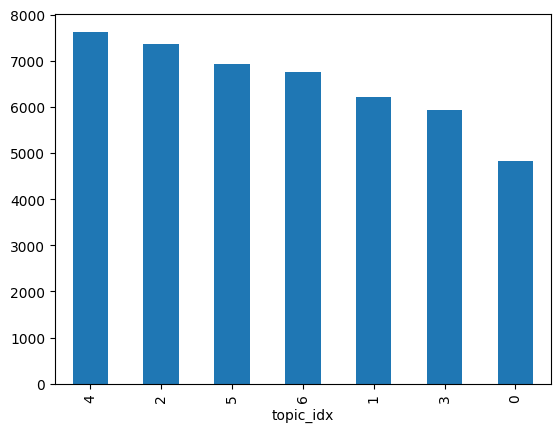

In [ ]:
train.topic_idx.value_counts().plot.bar()

In [ ]:
# 토픽별 평균 제목 길이
topic_len = train.groupby('topic_idx')['text_len'].mean().sort_values()
print(topic_len)

# 토픽별 단어 수 분포
train['word_count'] = train['title'].apply(lambda x: len(x.split()))
train.groupby('topic_idx')['word_count'].describe()


topic_idx
3    24.721389
2    26.458571
6    27.112132
1    27.325940
0    27.511816
5    28.785951
4    28.960939
Name: text_len, dtype: float64


,count,mean,std,min,25%,50%,75%,max
topic_idx,,,,,,,,
0,4824.0,6.645108,1.396392,1.0,6.0,7.0,8.0,11.0
1,6222.0,6.213918,1.294472,2.0,5.0,6.0,7.0,12.0
2,7362.0,6.315268,1.547828,1.0,5.0,6.0,7.0,12.0
3,5933.0,5.986853,1.695109,1.0,5.0,6.0,7.0,13.0
4,7629.0,7.283261,1.210905,2.0,6.0,7.0,8.0,11.0
5,6933.0,7.018751,1.225308,2.0,6.0,7.0,8.0,12.0
6,6751.0,6.491038,1.464807,1.0,6.0,7.0,7.0,12.0


##3. 데이터 전처리 및 모델링

###3-1. RandomForest

####(1) 단일모델

전처리

In [ ]:
import re

def clean_text(text):
  text = re.sub(r'[“”‘’]', '', text)
  text = re.sub(r'[^가-힣A-Za-z0-9\s]', ' ', text) # 한글, 영문, 숫자, 공백만 남김
  text = re.sub(r'\s+', ' ', text).strip() # 중복공백 제거
  return text

train['cleaned'] = train['title'].apply(clean_text)
test['cleaned'] = test['title'].apply(clean_text)
print('----train----')
print(train[['title', 'cleaned']])
print('----test----')
print(test[['title', 'cleaned']])

----train----
                                    title                             cleaned
0                인천→핀란드 항공기 결항…휴가철 여행객 분통            인천 핀란드 항공기 결항 휴가철 여행객 분통
1          실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화       실리콘밸리 넘어서겠다 구글 15조원 들여 전역 거점화
2          이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것      이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것
3        NYT 클린턴 측근韓기업 특수관계 조명…공과 사 맞물려종합    NYT 클린턴 측근 기업 특수관계 조명 공과 사 맞물려종합
4               시진핑 트럼프에 중미 무역협상 조속 타결 희망           시진핑 트럼프에 중미 무역협상 조속 타결 희망
...                                   ...                                 ...
45649        KB금융 미국 IB 스티펠과 제휴…선진국 시장 공략        KB금융 미국 IB 스티펠과 제휴 선진국 시장 공략
45650     1보 서울시교육청 신종코로나 확산에 개학 연기·휴업 검토     1보 서울시교육청 신종코로나 확산에 개학 연기 휴업 검토
45651         게시판 키움증권 2020 키움 영웅전 실전투자대회         게시판 키움증권 2020 키움 영웅전 실전투자대회
45652                   답변하는 배기동 국립중앙박물관장                   답변하는 배기동 국립중앙박물관장
45653  2020 한국인터넷기자상 시상식 내달 1일 개최…특별상 김성후  2020 한국인터넷기자상 시상식 내달 1일 개최 특별상 김성후

[45654 rows x 2 columns]
----test----
           

In [ ]:
!pip install kiwipiepy

In [ ]:
from kiwipiepy import Kiwi
kiwi = Kiwi()

def kiwi_tokenize(text):
    return [t.form for t in kiwi.tokenize(text)
            if t.tag.startswith(('N', 'M')) and len(t.form) > 1]

train['tokens'] = train['cleaned'].apply(kiwi_tokenize)
train['processed'] = train['tokens'].apply(lambda x: ' '.join(x))

test['tokens'] = test['cleaned'].apply(kiwi_tokenize)
test['processed'] = test['tokens'].apply(lambda x: ' '.join(x))

In [ ]:
train.head()

,index,title,topic_idx,cleaned,tokens,processed
0,0,인천→핀란드 항공기 결항…휴가철 여행객 분통,4,인천 핀란드 항공기 결항 휴가철 여행객 분통,"[인천, 핀란드, 항공기, 결항, 휴가철, 여행객, 분통]",인천 핀란드 항공기 결항 휴가철 여행객 분통
1,1,실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화,4,실리콘밸리 넘어서겠다 구글 15조원 들여 전역 거점화,"[실리콘밸리, 구글, 전역, 거점]",실리콘밸리 구글 전역 거점
2,2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,4,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,"[이란, 외무, 긴장, 완화, 해결책, 미국, 경제, 전쟁]",이란 외무 긴장 완화 해결책 미국 경제 전쟁
3,3,NYT 클린턴 측근韓기업 특수관계 조명…공과 사 맞물려종합,4,NYT 클린턴 측근 기업 특수관계 조명 공과 사 맞물려종합,"[클린턴, 측근, 기업, 특수, 관계, 조명, 공과, 종합]",클린턴 측근 기업 특수 관계 조명 공과 종합
4,4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,"[시진핑, 트럼프, 무역, 협상, 타결, 희망]",시진핑 트럼프 무역 협상 타결 희망


In [ ]:
test.head()

,index,title,cleaned,tokens,processed
0,45654,유튜브 내달 2일까지 크리에이터 지원 공간 운영,유튜브 내달 2일까지 크리에이터 지원 공간 운영,"[유튜브, 크리에이터, 지원, 공간, 운영]",유튜브 크리에이터 지원 공간 운영
1,45655,어버이날 맑다가 흐려져…남부지방 옅은 황사,어버이날 맑다가 흐려져 남부지방 옅은 황사,"[어버이날, 남부, 지방, 황사]",어버이날 남부 지방 황사
2,45656,내년부터 국가RD 평가 때 논문건수는 반영 않는다,내년부터 국가RD 평가 때 논문건수는 반영 않는다,"[내년, 국가, 평가, 논문, 건수, 반영]",내년 국가 평가 논문 건수 반영
3,45657,김명자 신임 과총 회장 원로와 젊은 과학자 지혜 모을 것,김명자 신임 과총 회장 원로와 젊은 과학자 지혜 모을 것,"[김명자, 신임, 과총, 회장, 원로, 과학자, 지혜]",김명자 신임 과총 회장 원로 과학자 지혜
4,45658,회색인간 작가 김동식 양심고백 등 새 소설집 2권 출간,회색인간 작가 김동식 양심고백 등 새 소설집 2권 출간,"[회색, 인간, 작가, 양심, 고백, 소설집, 출간]",회색 인간 작가 양심 고백 소설집 출간


In [ ]:
stopwords = set([
    '으로', '에서', '하다', '했다', '한다', '그리고', '그러나', '등',
    '대한', '관련', '위해', '통해', '대해', '것', '수', '이번', '지난', '지난해',
    '속보', '뉴스', '오늘', '내일', '기자', '보도', '사진'
])

def remove_stopwords(tokens):
    return [t for t in tokens if t not in stopwords]

train['tokens'] = train['tokens'].apply(remove_stopwords)
train['processed'] = train['tokens'].apply(lambda x: ' '.join(x))

test['tokens'] = test['tokens'].apply(remove_stopwords)
test['processed'] = test['tokens'].apply(lambda x: ' '.join(x))

In [ ]:
train.head()

,index,title,topic_idx,cleaned,tokens,processed
0,0,인천→핀란드 항공기 결항…휴가철 여행객 분통,4,인천 핀란드 항공기 결항 휴가철 여행객 분통,"[인천, 핀란드, 항공기, 결항, 휴가철, 여행객, 분통]",인천 핀란드 항공기 결항 휴가철 여행객 분통
1,1,실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화,4,실리콘밸리 넘어서겠다 구글 15조원 들여 전역 거점화,"[실리콘밸리, 구글, 전역, 거점]",실리콘밸리 구글 전역 거점
2,2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,4,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,"[이란, 외무, 긴장, 완화, 해결책, 미국, 경제, 전쟁]",이란 외무 긴장 완화 해결책 미국 경제 전쟁
3,3,NYT 클린턴 측근韓기업 특수관계 조명…공과 사 맞물려종합,4,NYT 클린턴 측근 기업 특수관계 조명 공과 사 맞물려종합,"[클린턴, 측근, 기업, 특수, 관계, 조명, 공과, 종합]",클린턴 측근 기업 특수 관계 조명 공과 종합
4,4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,"[시진핑, 트럼프, 무역, 협상, 타결, 희망]",시진핑 트럼프 무역 협상 타결 희망


In [ ]:
test.head()

,index,title,cleaned,tokens,processed
0,45654,유튜브 내달 2일까지 크리에이터 지원 공간 운영,유튜브 내달 2일까지 크리에이터 지원 공간 운영,"[유튜브, 크리에이터, 지원, 공간, 운영]",유튜브 크리에이터 지원 공간 운영
1,45655,어버이날 맑다가 흐려져…남부지방 옅은 황사,어버이날 맑다가 흐려져 남부지방 옅은 황사,"[어버이날, 남부, 지방, 황사]",어버이날 남부 지방 황사
2,45656,내년부터 국가RD 평가 때 논문건수는 반영 않는다,내년부터 국가RD 평가 때 논문건수는 반영 않는다,"[내년, 국가, 평가, 논문, 건수, 반영]",내년 국가 평가 논문 건수 반영
3,45657,김명자 신임 과총 회장 원로와 젊은 과학자 지혜 모을 것,김명자 신임 과총 회장 원로와 젊은 과학자 지혜 모을 것,"[김명자, 신임, 과총, 회장, 원로, 과학자, 지혜]",김명자 신임 과총 회장 원로 과학자 지혜
4,45658,회색인간 작가 김동식 양심고백 등 새 소설집 2권 출간,회색인간 작가 김동식 양심고백 등 새 소설집 2권 출간,"[회색, 인간, 작가, 양심, 고백, 소설집, 출간]",회색 인간 작가 양심 고백 소설집 출간


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    max_features = 30000,
    ngram_range = (1,2),
    min_df = 2,
    max_df = 0.9,
    sublinear_tf = True,
    norm = 'l2'
)

X_train = vectorizer.fit_transform(train['processed'])
X_test = vectorizer.transform(test['processed'])
y_train = train['topic_idx']

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (45654, 30000)
X_test shape: (9131, 30000)


모델링

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

pipeline = Pipeline([
    ('select', SelectKBest(chi2, k=15000)),  # 일단 기본값
    ('rf', RandomForestClassifier(random_state=42, n_jobs=-1))
])

param_dist = {
    'select__k': [10000, 15000, 20000],  # 피처 개수도 함께 튜닝
    'rf__n_estimators': randint(400, 1000),
    'rf__max_depth': [40, 60, 80, None],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4],
    'rf__max_features': ['sqrt', 'log2'],
    'rf__bootstrap': [True, False]
}

random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=10,
    cv=3,
    scoring='f1_macro',
    verbose=2,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('select',
                                              SelectKBest(k=15000,
                                                          score_func=<function chi2 at 0x7c859ccb5da0>)),
                                             ('rf',
                                              RandomForestClassifier(n_jobs=-1,
                                                                     random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'rf__bootstrap': [True, False],
                                        'rf__max_depth': [40, 60, 80, None],
                                        'rf__max_features': ['sqrt', 'log2'],
                                        'rf__min_samples_leaf': [1, 2, 4],
                                        'rf__min_samples_split': [2, 5, 10],
                                        'rf__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7c859c82b860>,
                                        'select__k': [10000, 15000, 20000]},
                   random_state=42, scoring='f1_macro', verbose=2)

In [ ]:
# 최적 모델로 test 예측
best_model = random_search.best_estimator_
pred = best_model.predict(X_test)

sample_submission['topic_idx'] = pred
sample_submission.to_csv('/content/drive/MyDrive/data/뉴스토픽_결과_11.csv', index=False)

print("Best Parameters:", random_search.best_params_)
print("Best CV Score (f1_macro):", random_search.best_score_)
print("제출 파일 저장 완료!")

Best Parameters: {'rf__bootstrap': True, 'rf__max_depth': None, 'rf__max_features': 'log2', 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 2, 'rf__n_estimators': 960, 'select__k': 20000}
Best CV Score (f1_macro): 0.7943565788948869
제출 파일 저장 완료!


####(2) Stacking

전처리

In [ ]:
!apt-get update
!apt-get install -y openjdk-11-jdk

Hit:1 https://cli.github.com/packages stable InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:6 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Fetched 257 kB in 2s (155 kB/s)
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provid

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["PATH"] += os.pathsep + os.path.join(os.environ["JAVA_HOME"], "bin")

In [ ]:
# 형태소 분석기(Okt) 불러오기
okt=Okt()

In [ ]:
# 조사, 어미, 구두점 제거
def func(text):
    clean = []
    for word in okt.pos(text, stem=True): #어간 추출
        if word[1] not in ['Josa', 'Eomi', 'Punctuation']: #조사, 어미, 구두점 제외
            clean.append(word[0])


    return " ".join(clean)

train['title'] = train['title'].apply(lambda x : func(x))

In [ ]:
# tf-idf를 이용한 벡터화
def split(text):
    tokens_ko = text.split()
    return tokens_ko

tfidf_vect = TfidfVectorizer(tokenizer=split, ngram_range=(1,2), max_features=8000)
tfidf_vect.fit(train['title'])
tfidf_matrix_train = tfidf_vect.transform(train['title'])

/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
# train/valid 데이터 셋 나누기.
def split_dataset(tfidf,df):
    X_data = tfidf
    y_data = df['topic_idx']

    # stratify=y_data Stratified 기반 분할, train 데이터의 30%를 평가 데이터 셋으로 사용. (70% 데이터 학습에 사용)
    X_train, X_test, y_train, y_test = \
    train_test_split(X_data, y_data, test_size=0.3, random_state=42, stratify=y_data)


    return (X_train, X_test, y_train, y_test)

X_train, X_test, y_train, y_test = split_dataset(tfidf_matrix_train,train)

모델 학습

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=42)

In [ ]:
# ===============================
# 검증 세트 성능 확인
# ===============================
val_pred = rf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, val_pred))
print("Macro F1:", f1_score(y_test, val_pred, average='macro'))

Accuracy: 0.797400890705994
Macro F1: 0.7995074227810507


스태킹

In [ ]:
import pandas as pd
import numpy as np
import re, os, time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, make_scorer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, StackingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

In [ ]:
# 후보 base/meta 세트 (소형)
base_model_sets = {
    'rf_et': [
        ('rf', RandomForestClassifier(n_estimators=150, max_depth=25, random_state=42, n_jobs=1)),
        ('et', ExtraTreesClassifier(n_estimators=150, max_depth=25, random_state=43, n_jobs=1))
    ],
    'rf_lgbm': [
        ('rf', RandomForestClassifier(n_estimators=150, max_depth=20, random_state=42, n_jobs=1)),
        ('lgb', LGBMClassifier(n_estimators=100, learning_rate=0.1, random_state=44, n_jobs=1))
    ]
}

meta_models = {
    'logreg': LogisticRegression(max_iter=1000),
    'lgbm': LGBMClassifier(n_estimators=150, learning_rate=0.05, random_state=42, n_jobs=1)
}

f1_macro = make_scorer(f1_score, average='macro')

results = []

print("스태킹 조합별 교차검증 시작...\n")
for set_name, base_models in base_model_sets.items():
    for meta_name, meta_model in meta_models.items():
        start = time.time()
        print(f"▶ Base={set_name} | Meta={meta_name}")
        stack_model = StackingClassifier(
            estimators=base_models,
            final_estimator=meta_model,
            cv=2,
            n_jobs=1,
            passthrough=True
        )
        pipe = Pipeline([
            ('select', SelectKBest(chi2, k=5000)),
            ('stack', stack_model)
        ])
        scores = cross_val_score(pipe, X_train, y_train, cv=2, scoring=f1_macro, n_jobs=1)
        mean_f1 = np.mean(scores)
        print(f"F1 Macro: {mean_f1:.4f} | Time: {time.time()-start:.1f}s\n")
        results.append((set_name, meta_name, mean_f1))

result_df = pd.DataFrame(results, columns=['BaseSet', 'MetaModel', 'F1_Macro'])
print("\n최적 조합 결과:")
print(result_df.sort_values(by='F1_Macro', ascending=False))

best_combo = result_df.sort_values(by='F1_Macro', ascending=False).iloc[0]
best_base = best_combo['BaseSet']
best_meta = best_combo['MetaModel']

print(f"\n최적 조합: Base={best_base}, Meta={best_meta}")

스태킹 조합별 교차검증 시작...

▶ Base=rf_et | Meta=logreg
F1 Macro: 0.8176 | Time: 54.3s

▶ Base=rf_et | Meta=lgbm
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.280314 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34486
[LightGBM] [Info] Number of data points in the train set: 15978, number of used features: 1476
[LightGBM] [Info] Start training from score -2.247076
[LightGBM] [Info] Start training from score -1.992806
[LightGBM] [Info] Start training from score -1.824975
[LightGBM] [Info] Start training from score -2.040770
[LightGBM] [Info] Start training from score -1.789134
[LightGBM] [Info] Start training from score -1.884969
[LightGBM] [Info] Start training from score -1.911281


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.280983 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34900
[LightGBM] [Info] Number of data points in the train set: 15979, number of used features: 1479
[LightGBM] [Info] Start training from score -2.247731
[LightGBM] [Info] Start training from score -1.993328
[LightGBM] [Info] Start training from score -1.824649
[LightGBM] [Info] Start training from score -2.040351
[LightGBM] [Info] Start training from score -1.789197
[LightGBM] [Info] Start training from score -1.884619
[LightGBM] [Info] Start training from score -1.911343


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


F1 Macro: 0.7687 | Time: 86.9s

▶ Base=rf_lgbm | Meta=logreg
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.174669 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 30916
[LightGBM] [Info] Number of data points in the train set: 15978, number of used features: 1462
[LightGBM] [Info] Start training from score -2.247076
[LightGBM] [Info] Start training from score -1.992806
[LightGBM] [Info] Start training from score -1.824975
[LightGBM] [Info] Start training from score -2.040770
[LightGBM] [Info] Start training from score -1.789134
[LightGBM] [Info] Start training from score -1.884969
[LightGBM] [Info] Start training from score -1.911281
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043394 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `f

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043314 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12431
[LightGBM] [Info] Number of data points in the train set: 7989, number of used features: 713
[LightGBM] [Info] Start training from score -2.247668
[LightGBM] [Info] Start training from score -1.992806
[LightGBM] [Info] Start training from score -1.824975
[LightGBM] [Info] Start training from score -2.040770
[LightGBM] [Info] Start training from score -1.789134
[LightGBM] [Info] Start training from score -1.884969
[LightGBM] [Info] Start training from score -1.910858


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.183081 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 31330
[LightGBM] [Info] Number of data points in the train set: 15979, number of used features: 1465
[LightGBM] [Info] Start training from score -2.247731
[LightGBM] [Info] Start training from score -1.993328
[LightGBM] [Info] Start training from score -1.824649
[LightGBM] [Info] Start training from score -2.040351
[LightGBM] [Info] Start training from score -1.789197
[LightGBM] [Info] Start training from score -1.884619
[LightGBM] [Info] Start training from score -1.911343
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043070 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12536
[Ligh

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.064982 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12554
[LightGBM] [Info] Number of data points in the train set: 7990, number of used features: 722
[LightGBM] [Info] Start training from score -2.247794
[LightGBM] [Info] Start training from score -1.993850
[LightGBM] [Info] Start training from score -1.825100
[LightGBM] [Info] Start training from score -2.039932
[LightGBM] [Info] Start training from score -1.789259
[LightGBM] [Info] Start training from score -1.884270
[LightGBM] [Info] Start training from score -1.910983


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


F1 Macro: 0.8137 | Time: 81.0s

▶ Base=rf_lgbm | Meta=lgbm
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.275376 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 30916
[LightGBM] [Info] Number of data points in the train set: 15978, number of used features: 1462
[LightGBM] [Info] Start training from score -2.247076
[LightGBM] [Info] Start training from score -1.992806
[LightGBM] [Info] Start training from score -1.824975
[LightGBM] [Info] Start training from score -2.040770
[LightGBM] [Info] Start training from score -1.789134
[LightGBM] [Info] Start training from score -1.884969
[LightGBM] [Info] Start training from score -1.911281
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043152 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `for

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042816 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12431
[LightGBM] [Info] Number of data points in the train set: 7989, number of used features: 713
[LightGBM] [Info] Start training from score -2.247668
[LightGBM] [Info] Start training from score -1.992806
[LightGBM] [Info] Start training from score -1.824975
[LightGBM] [Info] Start training from score -2.040770
[LightGBM] [Info] Start training from score -1.789134
[LightGBM] [Info] Start training from score -1.884969
[LightGBM] [Info] Start training from score -1.910858


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.173978 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34486
[LightGBM] [Info] Number of data points in the train set: 15978, number of used features: 1476
[LightGBM] [Info] Start training from score -2.247076
[LightGBM] [Info] Start training from score -1.992806
[LightGBM] [Info] Start training from score -1.824975
[LightGBM] [Info] Start training from score -2.040770
[LightGBM] [Info] Start training from score -1.789134
[LightGBM] [Info] Start training from score -1.884969
[LightGBM] [Info] Start training from score -1.911281


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.173484 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 31330
[LightGBM] [Info] Number of data points in the train set: 15979, number of used features: 1465
[LightGBM] [Info] Start training from score -2.247731
[LightGBM] [Info] Start training from score -1.993328
[LightGBM] [Info] Start training from score -1.824649
[LightGBM] [Info] Start training from score -2.040351
[LightGBM] [Info] Start training from score -1.789197
[LightGBM] [Info] Start training from score -1.884619
[LightGBM] [Info] Start training from score -1.911343
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042570 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12536
[Ligh

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044886 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12554
[LightGBM] [Info] Number of data points in the train set: 7990, number of used features: 722
[LightGBM] [Info] Start training from score -2.247794
[LightGBM] [Info] Start training from score -1.993850
[LightGBM] [Info] Start training from score -1.825100
[LightGBM] [Info] Start training from score -2.039932
[LightGBM] [Info] Start training from score -1.789259
[LightGBM] [Info] Start training from score -1.884270
[LightGBM] [Info] Start training from score -1.910983


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.285053 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34900
[LightGBM] [Info] Number of data points in the train set: 15979, number of used features: 1479
[LightGBM] [Info] Start training from score -2.247731
[LightGBM] [Info] Start training from score -1.993328
[LightGBM] [Info] Start training from score -1.824649
[LightGBM] [Info] Start training from score -2.040351
[LightGBM] [Info] Start training from score -1.789197
[LightGBM] [Info] Start training from score -1.884619
[LightGBM] [Info] Start training from score -1.911343


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


F1 Macro: 0.7783 | Time: 111.1s


최적 조합 결과:
   BaseSet MetaModel  F1_Macro
0    rf_et    logreg  0.817587
2  rf_lgbm    logreg  0.813724
3  rf_lgbm      lgbm  0.778340
1    rf_et      lgbm  0.768721

최적 조합: Base=rf_et, Meta=logreg


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression

# 최적 조합 설정
base_models = [
    ('rf', RandomForestClassifier(n_estimators=150, max_depth=25, random_state=42, n_jobs=1)),
    ('et', ExtraTreesClassifier(n_estimators=150, max_depth=25, random_state=43, n_jobs=1))
]
meta_model = LogisticRegression(max_iter=1000)

# 스태킹 모델 정의
final_stack = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    cv=3,
    n_jobs=1,
    passthrough=True
)

# 최종 파이프라인
final_pipe = Pipeline([
    ('select', SelectKBest(chi2, k=5000)),
    ('stack', final_stack)
])

# 전체 학습 데이터로 재학습
print("최적 스태킹 모델 학습 시작...")
final_pipe.fit(tfidf_matrix_train, train['topic_idx'])

# 테스트 데이터 전처리
test['title'] = test['title'].apply(lambda x : func(x))
tfidf_matrix_test = tfidf_vect.transform(test['title'])

# 테스트 데이터 예측
pred = final_pipe.predict(tfidf_matrix_test)

# 제출 파일 생성
sample_submission['topic_idx'] = pred
output_path = '/content/drive/MyDrive/data/뉴스토픽_최종_rf_et_logreg.csv'
sample_submission.to_csv(output_path, index=False)
print(f"\n 최적 스태킹 모델 예측 완료! 제출 파일 저장: {output_path}")

최적 스태킹 모델 학습 시작...

 최적 스태킹 모델 예측 완료! 제출 파일 저장: /content/drive/MyDrive/data/뉴스토픽_최종_rf_et_logreg.csv


###3-2. LightGBM

#### (1) 단일모델

전처리

In [ ]:
!pip install konlpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 57.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 495.9/495.9 kB 28.6 MB/s eta 0:00:00


In [ ]:
!apt-get update
!apt-get install openjdk-17-jdk -y
!pip install konlpy

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-17-openjdk-amd64"
os.environ["PATH"] += os.pathsep + os.path.join(os.environ["JAVA_HOME"], "bin")

Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 https://cli.github.com/packages stable InRelease [3,917 B]
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,138 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:8 https://cli.github.com/packages stable/main amd64 Packages [343 B]
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 http://archive.ubuntu.com/ubuntu jammy-backports InReleas

In [ ]:
import pandas as pd
import re
from konlpy.tag import Okt,Mecab
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score,f1_score
from xgboost import XGBClassifier

In [ ]:
# 형태소 분석기(Okt) 불러오기
okt=Okt()

In [ ]:
# 조사, 어미, 구두점 제거
def func(text):
    clean = []
    for word in okt.pos(text, stem=True):
        if word[1] not in ['Josa', 'Eomi', 'Punctuation']:
            clean.append(word[0])


    return " ".join(clean)

train['title'] = train['title'].apply(lambda x : func(x))

In [ ]:
# tf-idf를 이용한 벡터화
def split(text):
    tokens_ko = text.split()
    return tokens_ko

tfidf_vect = TfidfVectorizer(tokenizer=split)
tfidf_vect.fit(train['title'])
tfidf_matrix_train = tfidf_vect.transform(train['title'])

/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


모델링

In [ ]:
# train/valid 데이터 셋 나누기
def split_dataset(tfidf,df):
    X_data = tfidf
    y_data = df['topic_idx']

    X_train, X_test, y_train, y_test = \
    train_test_split(X_data, y_data, test_size=0.3, random_state=42, stratify=y_data)


    return (X_train, X_test, y_train, y_test)

X_train, X_test, y_train, y_test = split_dataset(tfidf_matrix_train, train)

In [ ]:
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(
    random_state=42,
    n_estimators=300,
    learning_rate=0.05,
    num_leaves=31
)

In [ ]:
lgbm.fit(X_train, y_train)
pred = lgbm.predict(X_test)

print("기본 정확도:", accuracy_score(y_test, pred))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.578457 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74984
[LightGBM] [Info] Number of data points in the train set: 31957, number of used features: 2872
[LightGBM] [Info] Start training from score -2.247404
[LightGBM] [Info] Start training from score -1.993067
[LightGBM] [Info] Start training from score -1.824812
[LightGBM] [Info] Start training from score -2.040560
[LightGBM] [Info] Start training from score -1.789166
[LightGBM] [Info] Start training from score -1.884794
[LightGBM] [Info] Start training from score -1.911312


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


기본 정확도: 0.815653062714463


하이퍼파라미터 튜닝 (Randomized Search CV)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import accuracy_score
from scipy.stats import randint, uniform

In [ ]:
params = {
    'n_estimators': randint(100, 300),
    'max_depth': [3, 5, 7],
    'learning_rate': uniform(0.05, 0.1),
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
    'reg_lambda': [0.1, 1, 10]
}

random_search = RandomizedSearchCV(
    lgbm,
    param_distributions=params,
    n_iter=5,
    cv=3,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)

print("Best Parameters:")
print(random_search.best_params_)

print("Best Accuracy:", random_search.best_score_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Parameters:
{'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': np.float64(0.10247746602583892), 'max_depth': 7, 'n_estimators': 269, 'reg_lambda': 10, 'subsample': 1.0}
Best Accuracy: 0.7698157598820785


In [ ]:
best_model = random_search.best_estimator_

test['title'] = test['title'].apply(lambda x: func(x))
tfidf_matrix_test = tfidf_vect.transform(test['title'])
test_pred = best_model.predict(tfidf_matrix_test)

submission['topic_idx'] = test_pred
submission.to_csv('뉴스분류_LGBM.csv', index=False, encoding='utf-8-sig')

(2) Stacking

전처리

In [ ]:
!pip install konlpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 97.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 495.9/495.9 kB 27.5 MB/s eta 0:00:00


In [ ]:
!apt-get update
!apt-get install openjdk-17-jdk -y
!pip install konlpy

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-17-openjdk-amd64"
os.environ["PATH"] += os.pathsep + os.path.join(os.environ["JAVA_HOME"], "bin")

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://cli.github.com/packages stable InRelease [3,917 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 https://cli.github.com/packages stable/main amd64 Packages [343 B]
Hit:7 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,138 kB]
Get:9 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,825 kB]
Hit:12 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:13 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu

In [ ]:
import pandas as pd
import re
from konlpy.tag import Okt,Mecab
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score,f1_score
from xgboost import XGBClassifier

In [ ]:
# 형태소 분석기(Okt) 불러오기
okt=Okt()

In [ ]:
# 조사, 어미, 구두점 제거
def func(text):
    clean = []
    for word in okt.pos(text, stem=True):
        if word[1] not in ['Josa', 'Eomi', 'Punctuation']:
            clean.append(word[0])


    return " ".join(clean)

train['title'] = train['title'].apply(lambda x : func(x))
test['title'] = test['title'].apply(lambda x: func(x))

In [ ]:
# tf-idf를 이용한 벡터화
tfidf_vect = TfidfVectorizer(
    tokenizer=lambda x: x.split(),
    ngram_range=(1, 2),
    min_df=3,
    max_df=0.9
)

tfidf_matrix_train = tfidf_vect.fit_transform(train['title'])
tfidf_matrix_test = tfidf_vect.transform(test['title'])

/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


모델링

In [ ]:
# train/valid 데이터 셋 나누기
def split_dataset(tfidf,df):
    X_data = tfidf
    y_data = df['topic_idx']

    X_train, X_test, y_train, y_test = \
    train_test_split(X_data, y_data, test_size=0.3, random_state=42, stratify=y_data)


    return (X_train, X_test, y_train, y_test)

X_train, X_test, y_train, y_test = split_dataset(tfidf_matrix_train, train)

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

In [ ]:
base_model_combinations = {
    "Combo1": [
        ('lgb1', LGBMClassifier(n_estimators=70, max_depth=5, learning_rate=0.07)),
        ('rf', RandomForestClassifier(n_estimators=80, max_depth=7, random_state=42))
    ],
    "Combo2": [
        ('lgb1', LGBMClassifier(n_estimators=70, max_depth=5, learning_rate=0.07)),
        ('lr', LogisticRegression(max_iter=500))
    ],
    "Combo3": [
        ('lgb1', LGBMClassifier(n_estimators=70, max_depth=5, learning_rate=0.07)),
        ('nb', MultinomialNB())
    ],
    "Combo4": [
        ('lgb1', LGBMClassifier(n_estimators=70, max_depth=5, learning_rate=0.07)),
        ('lgb2', LGBMClassifier(n_estimators=50, max_depth=3, learning_rate=0.1))
    ]
}

In [ ]:
meta_models = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "RidgeClassifier": RidgeClassifier()
}

In [ ]:
results = {}

for combo_name, base_models in base_model_combinations.items():
    for meta_name, meta_model in meta_models.items():
        model_name = f"{combo_name} + {meta_name}"
        print(f"Training {model_name} ...")

        stacking_model = StackingClassifier(
            estimators=base_models,
            final_estimator=meta_model,
            cv=3,
            n_jobs=-1
        )

        stacking_model.fit(X_train, y_train)
        y_pred = stacking_model.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='macro')

        results[model_name] = {"Accuracy": acc, "F1": f1}
        print(f"{model_name} => Accuracy: {acc:.4f}, F1: {f1:.4f}\n")

results_df = pd.DataFrame(results).T.sort_values(by="Accuracy", ascending=False)

Training Combo1 + LogisticRegression ...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Combo1 + LogisticRegression => Accuracy: 0.7312, F1: 0.7445

Training Combo1 + RidgeClassifier ...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Combo1 + RidgeClassifier => Accuracy: 0.7330, F1: 0.7462

Training Combo2 + LogisticRegression ...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Combo2 + LogisticRegression => Accuracy: 0.8463, F1: 0.8459

Training Combo2 + RidgeClassifier ...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Combo2 + RidgeClassifier => Accuracy: 0.8461, F1: 0.8454

Training Combo3 + LogisticRegression ...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Combo3 + LogisticRegression => Accuracy: 0.8485, F1: 0.8479

Training Combo3 + RidgeClassifier ...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Combo3 + RidgeClassifier => Accuracy: 0.8459, F1: 0.8449

Training Combo4 + LogisticRegression ...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Combo4 + LogisticRegression => Accuracy: 0.7379, F1: 0.7505

Training Combo4 + RidgeClassifier ...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Combo4 + RidgeClassifier => Accuracy: 0.7526, F1: 0.7630



In [ ]:
base_models = [
    ('lgb1', LGBMClassifier(n_estimators=100, max_depth=5, learning_rate=0.07)),
    ('nb', MultinomialNB())
]

meta_model = LogisticRegression(max_iter=1000)

# TF-IDF 다시 fit (최종 full train 용)
tfidf_vect = TfidfVectorizer(tokenizer=lambda x: x.split())
tfidf_vect.fit(train['title'])

X_train_full = tfidf_vect.transform(train['title'])
y_train_full = train['topic_idx']

X_test_full = tfidf_vect.transform(test['title'])

stacking_model = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    cv=3,
    n_jobs=-1
)

stacking_model.fit(X_train_full, y_train_full)

y_pred_test = stacking_model.predict(X_test_full)
submission['topic_idx'] = y_pred_test
submission.to_csv("news_lgbm_stack.csv", index=False)

/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


###3-3. XGBoost

####(1) 단일모델

전처리

In [ ]:
!pip install konlpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 79.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 495.9/495.9 kB 28.1 MB/s eta 0:00:00


In [ ]:
!apt-get update
!apt-get install openjdk-17-jdk -y
!pip install konlpy

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-17-openjdk-amd64"
os.environ["PATH"] += os.pathsep + os.path.join(os.environ["JAVA_HOME"], "bin")

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:2 https://cli.github.com/packages stable InRelease
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:9 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [5,982 kB]
Get:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,130 kB]
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 http://archive.ubuntu.com/ubuntu jammy-backports

In [ ]:
import pandas as pd
import re
from konlpy.tag import Okt,Mecab
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score,f1_score
from xgboost import XGBClassifier

In [ ]:
# 형태소 분석기(Okt) 불러오기
okt=Okt()

In [ ]:
# 조사, 어미, 구두점 제거
def func(text):
    clean = []
    for word in okt.pos(text, stem=True): #어간 추출
        if word[1] not in ['Josa', 'Eomi', 'Punctuation']: #조사, 어미, 구두점 제외
            clean.append(word[0])


    return " ".join(clean)

train['title'] = train['title'].apply(lambda x : func(x))

In [ ]:
# tf-idf를 이용한 벡터화
def split(text):
    tokens_ko = text.split()
    return tokens_ko

tfidf_vect = TfidfVectorizer(tokenizer=split)
tfidf_vect.fit(train['title'])
tfidf_matrix_train = tfidf_vect.transform(train['title'])

/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


모델링

In [ ]:
# train/valid 데이터 셋 나누기.
def split_dataset(tfidf,df):
    X_data = tfidf
    y_data = df['topic_idx']

    # stratify=y_data Stratified 기반 분할, train 데이터의 30%를 평가 데이터 셋으로 사용. (70% 데이터 학습에 사용)
    X_train, X_test, y_train, y_test = \
    train_test_split(X_data, y_data, test_size=0.3, random_state=42, stratify=y_data)


    return (X_train, X_test, y_train, y_test)

X_train, X_test, y_train, y_test = split_dataset(tfidf_matrix_train, train)

In [ ]:
xgb = XGBClassifier(random_state=42)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
pred = xgb.predict(X_test)
accuracy = accuracy_score(y_test,pred)

print('정확도', accuracy)

정확도 0.7973278820179601


하이퍼파라미터 튜닝

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from scipy.stats import randint, uniform

In [ ]:
xgb = XGBClassifier(
    random_state=42,
    n_jobs=-1,
    eval_metric='mlogloss'  # 경고 방지용
)

In [ ]:
params = {
    'n_estimators': randint(100, 300),
    'max_depth': [3, 5, 7],
    'learning_rate': uniform(0.05, 0.1),
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
    'reg_lambda': [0.1, 1, 10]
}

random_search = RandomizedSearchCV(
    xgb,
    param_distributions=params,
    n_iter=5,
    cv=3,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)

print("Best Parameters:")
print(random_search.best_params_)

print("Best Accuracy:", random_search.best_score_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Parameters:
{'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': np.float64(0.10247746602583892), 'max_depth': 7, 'n_estimators': 269, 'reg_lambda': 10, 'subsample': 1.0}
Best Accuracy: 0.7698157598820785


In [ ]:
best_model = random_search.best_estimator_

test['title'] = test['title'].apply(lambda x: func(x))
tfidf_matrix_test = tfidf_vect.transform(test['title'])
test_pred = best_model.predict(tfidf_matrix_test)

submission['topic_idx'] = test_pred
submission.to_csv('news_xgb_real.csv', index=False, encoding='utf-8-sig')

####(2) Stacking

전처리

In [ ]:
!pip install konlpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 112.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 495.9/495.9 kB 46.4 MB/s eta 0:00:00


In [ ]:
!apt-get update
!apt-get install openjdk-17-jdk -y
!pip install konlpy

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-17-openjdk-amd64"
os.environ["PATH"] += os.pathsep + os.path.join(os.environ["JAVA_HOME"], "bin")

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:2 https://cli.github.com/packages stable InRelease
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,130 kB]
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:10 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,825 kB]
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [

In [ ]:
import pandas as pd
import re
from konlpy.tag import Okt,Mecab
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score,f1_score
from xgboost import XGBClassifier

In [ ]:
# 형태소 분석기(Okt) 불러오기
okt=Okt()

In [ ]:
# 조사, 어미, 구두점 제거
def func(text):
    clean = []
    for word in okt.pos(text, stem=True): #어간 추출
        if word[1] not in ['Josa', 'Eomi', 'Punctuation']: #조사, 어미, 구두점 제외
            clean.append(word[0])


    return " ".join(clean)

train['title'] = train['title'].apply(lambda x : func(x))
test['title'] = test['title'].apply(lambda x: func(x))

In [ ]:
# tf-idf를 이용한 벡터화
tfidf_vect = TfidfVectorizer(
    tokenizer=lambda x: x.split(),
    ngram_range=(1, 2),
    min_df=3,
    max_df=0.9
)

tfidf_matrix_train = tfidf_vect.fit_transform(train['title'])
tfidf_matrix_test = tfidf_vect.transform(test['title'])

/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


모델링

In [ ]:
# train/valid 데이터 셋 나누기.
def split_dataset(tfidf,df):
    X_data = tfidf
    y_data = df['topic_idx']

    # stratify=y_data Stratified 기반 분할, train 데이터의 30%를 평가 데이터 셋으로 사용. (70% 데이터 학습에 사용)
    X_train, X_test, y_train, y_test = \
    train_test_split(X_data, y_data, test_size=0.3, random_state=42, stratify=y_data)


    return (X_train, X_test, y_train, y_test)

X_train, X_test, y_train, y_test = split_dataset(tfidf_matrix_train, train)

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, f1_score

In [ ]:
base_model_combinations = {
    "Combo1": [('xgb', XGBClassifier(eval_metric='mlogloss', n_estimators=50, max_depth=3)),
               ('rf', RandomForestClassifier(n_estimators=50, max_depth=5, random_state=42))],

    "Combo2": [('xgb', XGBClassifier(eval_metric='mlogloss', n_estimators=50, max_depth=3)),
               ('lr', LogisticRegression(max_iter=500))],

    "Combo3": [('xgb', XGBClassifier(eval_metric='mlogloss', n_estimators=50, max_depth=3)),
               ('nb', MultinomialNB())],

    "Combo4": [('xgb', XGBClassifier(eval_metric='mlogloss', n_estimators=50, max_depth=3)),
               ('lgb', LGBMClassifier(n_estimators=50, max_depth=5))]
}

In [ ]:
meta_models = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "RidgeClassifier": RidgeClassifier()
}

In [ ]:
results = {}

for combo_name, base_models in base_model_combinations.items():
    for meta_name, meta_model in meta_models.items():
        model_name = f"{combo_name} + {meta_name}"
        print(f"Training {model_name} ...")

        stacking_model = StackingClassifier(
            estimators=base_models,
            final_estimator=meta_model,
            cv=3,
            n_jobs=-1
        )

        stacking_model.fit(X_train, y_train)
        y_pred = stacking_model.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='macro')

        results[model_name] = {"Accuracy": acc, "F1": f1}
        print(f"{model_name} => Accuracy: {acc:.4f}, F1: {f1:.4f}\n")

Training Combo1 + LogisticRegression ...
Combo1 + LogisticRegression => Accuracy: 0.7376, F1: 0.7494

Training Combo1 + RidgeClassifier ...
Combo1 + RidgeClassifier => Accuracy: 0.7399, F1: 0.7515

Training Combo2 + LogisticRegression ...
Combo2 + LogisticRegression => Accuracy: 0.8463, F1: 0.8458

Training Combo2 + RidgeClassifier ...
Combo2 + RidgeClassifier => Accuracy: 0.8464, F1: 0.8457

Training Combo3 + LogisticRegression ...
Combo3 + LogisticRegression => Accuracy: 0.8479, F1: 0.8473

Training Combo3 + RidgeClassifier ...
Combo3 + RidgeClassifier => Accuracy: 0.8462, F1: 0.8452

Training Combo4 + LogisticRegression ...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Combo4 + LogisticRegression => Accuracy: 0.7383, F1: 0.7507

Training Combo4 + RidgeClassifier ...
Combo4 + RidgeClassifier => Accuracy: 0.7399, F1: 0.7522



/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [ ]:
results_df = pd.DataFrame(results).T.sort_values(by="Accuracy", ascending=False)
print(results_df)

                             Accuracy        F1
Combo3 + LogisticRegression  0.847923  0.847310
Combo2 + RidgeClassifier     0.846390  0.845675
Combo2 + LogisticRegression  0.846317  0.845837
Combo3 + RidgeClassifier     0.846171  0.845171
Combo4 + RidgeClassifier     0.739943  0.752244
Combo1 + RidgeClassifier     0.739870  0.751477
Combo4 + LogisticRegression  0.738337  0.750656
Combo1 + LogisticRegression  0.737607  0.749365


In [ ]:
tfidf_vect = TfidfVectorizer(tokenizer=lambda x: x.split())
tfidf_vect.fit(train['title'])

X_train_full = tfidf_vect.transform(train['title'])
y_train_full = train['topic_idx']

X_test_full = tfidf_vect.transform(test['title'])

base_models = [
    ('xgb', XGBClassifier(eval_metric='mlogloss', n_estimators=100, max_depth=3)),
    ('nb', MultinomialNB())
]
meta_model = LogisticRegression(max_iter=1000)

stacking_model = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    cv=3,
    n_jobs=-1
)

stacking_model.fit(X_train_full, y_train_full)

y_pred_test = stacking_model.predict(X_test_full)
submission['topic_idx'] = y_pred_test
submission.to_csv("news_xgb_stack.csv", index=False)

/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


###3-4. Soft Voting

#####전처리

텍스트 정제

In [ ]:
import re

def clean_text(text):
  text = re.sub(r'[“”‘’]', '', text)
  text = re.sub(r'[^가-힣A-Za-z0-9\s]', ' ', text) # 한글, 영문, 숫자, 공백만 남김
  text = re.sub(r'\s+', ' ', text).strip() # 중복공백 제거
  return text

train['cleaned'] = train['title'].apply(clean_text)
test['cleaned'] = test['title'].apply(clean_text)
print('----train----')
print(train[['title', 'cleaned']])
print('----test----')
print(test[['title', 'cleaned']])

----train----
                                    title                             cleaned
0                인천→핀란드 항공기 결항…휴가철 여행객 분통            인천 핀란드 항공기 결항 휴가철 여행객 분통
1          실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화       실리콘밸리 넘어서겠다 구글 15조원 들여 전역 거점화
2          이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것      이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것
3        NYT 클린턴 측근韓기업 특수관계 조명…공과 사 맞물려종합    NYT 클린턴 측근 기업 특수관계 조명 공과 사 맞물려종합
4               시진핑 트럼프에 중미 무역협상 조속 타결 희망           시진핑 트럼프에 중미 무역협상 조속 타결 희망
...                                   ...                                 ...
45649        KB금융 미국 IB 스티펠과 제휴…선진국 시장 공략        KB금융 미국 IB 스티펠과 제휴 선진국 시장 공략
45650     1보 서울시교육청 신종코로나 확산에 개학 연기·휴업 검토     1보 서울시교육청 신종코로나 확산에 개학 연기 휴업 검토
45651         게시판 키움증권 2020 키움 영웅전 실전투자대회         게시판 키움증권 2020 키움 영웅전 실전투자대회
45652                   답변하는 배기동 국립중앙박물관장                   답변하는 배기동 국립중앙박물관장
45653  2020 한국인터넷기자상 시상식 내달 1일 개최…특별상 김성후  2020 한국인터넷기자상 시상식 내달 1일 개최 특별상 김성후

[45654 rows x 2 columns]
----test----
           

토큰화

In [ ]:
!pip install kiwipiepy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.5/35.5 MB 31.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 104.6 MB/s eta 0:00:00
  Created wheel for kiwipiepy_model: filename=kiwipiepy_model-0.21.0-py3-none-any.whl size=35593192 sha256=1ff9fb7ca6c4bd84b69a5dc0af67ea65256e071c83450d25dbdc6dc5561c73b0
  Stored in directory: /root/.cache/pip/wheels/5f/94/81/3e8b1478625f1bdb3b72733dfe3086a8f77a8f25db2b1d746b
Successfully built kiwipiepy_model


In [ ]:
from kiwipiepy import Kiwi
kiwi = Kiwi()

def kiwi_tokenize(text):
    return [t.form for t in kiwi.tokenize(text)
            if len(t.form) > 1 and t.tag.startswith(('N', 'V', 'M'))]

train['tokens'] = train['cleaned'].apply(kiwi_tokenize)
train['processed'] = train['tokens'].apply(lambda x: ' '.join(x))

test['tokens'] = test['cleaned'].apply(kiwi_tokenize)
test['processed'] = test['tokens'].apply(lambda x: ' '.join(x))

In [ ]:
train.head()

,index,title,topic_idx,cleaned,tokens,processed
0,0,인천→핀란드 항공기 결항…휴가철 여행객 분통,4,인천 핀란드 항공기 결항 휴가철 여행객 분통,"[인천, 핀란드, 항공기, 결항, 휴가철, 여행객, 분통]",인천 핀란드 항공기 결항 휴가철 여행객 분통
1,1,실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화,4,실리콘밸리 넘어서겠다 구글 15조원 들여 전역 거점화,"[실리콘밸리, 넘어서, 구글, 들이, 전역, 거점]",실리콘밸리 넘어서 구글 들이 전역 거점
2,2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,4,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,"[이란, 외무, 긴장, 완화, 해결책, 미국, 경제, 전쟁, 멈추]",이란 외무 긴장 완화 해결책 미국 경제 전쟁 멈추
3,3,NYT 클린턴 측근韓기업 특수관계 조명…공과 사 맞물려종합,4,NYT 클린턴 측근 기업 특수관계 조명 공과 사 맞물려종합,"[클린턴, 측근, 기업, 특수, 관계, 조명, 공과, 맞물리, 종합]",클린턴 측근 기업 특수 관계 조명 공과 맞물리 종합
4,4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,"[시진핑, 트럼프, 무역, 협상, 타결, 희망]",시진핑 트럼프 무역 협상 타결 희망


In [ ]:
test.head()

,index,title,cleaned,tokens,processed
0,45654,유튜브 내달 2일까지 크리에이터 지원 공간 운영,유튜브 내달 2일까지 크리에이터 지원 공간 운영,"[유튜브, 크리에이터, 지원, 공간, 운영]",유튜브 크리에이터 지원 공간 운영
1,45655,어버이날 맑다가 흐려져…남부지방 옅은 황사,어버이날 맑다가 흐려져 남부지방 옅은 황사,"[어버이날, 흐리, 남부, 지방, 황사]",어버이날 흐리 남부 지방 황사
2,45656,내년부터 국가RD 평가 때 논문건수는 반영 않는다,내년부터 국가RD 평가 때 논문건수는 반영 않는다,"[내년, 국가, 평가, 논문, 건수, 반영]",내년 국가 평가 논문 건수 반영
3,45657,김명자 신임 과총 회장 원로와 젊은 과학자 지혜 모을 것,김명자 신임 과총 회장 원로와 젊은 과학자 지혜 모을 것,"[김명자, 신임, 과총, 회장, 원로, 과학자, 지혜, 모으]",김명자 신임 과총 회장 원로 과학자 지혜 모으
4,45658,회색인간 작가 김동식 양심고백 등 새 소설집 2권 출간,회색인간 작가 김동식 양심고백 등 새 소설집 2권 출간,"[회색, 인간, 작가, 양심, 고백, 소설집, 출간]",회색 인간 작가 양심 고백 소설집 출간


stopwords

In [ ]:
stopwords = set([
    '으로', '에서', '하다', '했다', '한다', '그리고', '그러나', '등',
    '대한', '관련', '위해', '통해', '대해', '것', '수', '이번', '지난', '지난해'
])

def remove_stopwords(tokens):
    return [t for t in tokens if t not in stopwords]

train['tokens'] = train['tokens'].apply(remove_stopwords)
train['processed'] = train['tokens'].apply(lambda x: ' '.join(x))

test['tokens'] = test['tokens'].apply(remove_stopwords)
test['processed'] = test['tokens'].apply(lambda x: ' '.join(x))

In [ ]:
train.head()

,index,title,topic_idx,cleaned,tokens,processed
0,0,인천→핀란드 항공기 결항…휴가철 여행객 분통,4,인천 핀란드 항공기 결항 휴가철 여행객 분통,"[인천, 핀란드, 항공기, 결항, 휴가철, 여행객, 분통]",인천 핀란드 항공기 결항 휴가철 여행객 분통
1,1,실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화,4,실리콘밸리 넘어서겠다 구글 15조원 들여 전역 거점화,"[실리콘밸리, 넘어서, 구글, 들이, 전역, 거점]",실리콘밸리 넘어서 구글 들이 전역 거점
2,2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,4,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,"[이란, 외무, 긴장, 완화, 해결책, 미국, 경제, 전쟁, 멈추]",이란 외무 긴장 완화 해결책 미국 경제 전쟁 멈추
3,3,NYT 클린턴 측근韓기업 특수관계 조명…공과 사 맞물려종합,4,NYT 클린턴 측근 기업 특수관계 조명 공과 사 맞물려종합,"[클린턴, 측근, 기업, 특수, 관계, 조명, 공과, 맞물리, 종합]",클린턴 측근 기업 특수 관계 조명 공과 맞물리 종합
4,4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,"[시진핑, 트럼프, 무역, 협상, 타결, 희망]",시진핑 트럼프 무역 협상 타결 희망


In [ ]:
test.head()

,index,title,cleaned,tokens,processed
0,45654,유튜브 내달 2일까지 크리에이터 지원 공간 운영,유튜브 내달 2일까지 크리에이터 지원 공간 운영,"[유튜브, 크리에이터, 지원, 공간, 운영]",유튜브 크리에이터 지원 공간 운영
1,45655,어버이날 맑다가 흐려져…남부지방 옅은 황사,어버이날 맑다가 흐려져 남부지방 옅은 황사,"[어버이날, 흐리, 남부, 지방, 황사]",어버이날 흐리 남부 지방 황사
2,45656,내년부터 국가RD 평가 때 논문건수는 반영 않는다,내년부터 국가RD 평가 때 논문건수는 반영 않는다,"[내년, 국가, 평가, 논문, 건수, 반영]",내년 국가 평가 논문 건수 반영
3,45657,김명자 신임 과총 회장 원로와 젊은 과학자 지혜 모을 것,김명자 신임 과총 회장 원로와 젊은 과학자 지혜 모을 것,"[김명자, 신임, 과총, 회장, 원로, 과학자, 지혜, 모으]",김명자 신임 과총 회장 원로 과학자 지혜 모으
4,45658,회색인간 작가 김동식 양심고백 등 새 소설집 2권 출간,회색인간 작가 김동식 양심고백 등 새 소설집 2권 출간,"[회색, 인간, 작가, 양심, 고백, 소설집, 출간]",회색 인간 작가 양심 고백 소설집 출간


TF-IDF 벡터화

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    max_features = 20000,
    ngram_range = (1,3),
    min_df = 2,
    max_df = 0.95,
    sublinear_tf = True
)

X_train = vectorizer.fit_transform(train['processed'])
X_test = vectorizer.transform(test['processed'])
y_train = train['topic_idx']

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (45654, 20000)
X_test shape: (9131, 20000)


모델링

In [ ]:
#  Voting Model

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# 1) Logistic Regression
log_reg = LogisticRegression(
    max_iter=2000,
    C=3,
    n_jobs=-1
)

# 2) RandomForest
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    n_jobs=-1,
    random_state=42
)

# 3) LightGBM
lgbm = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=-1,
    random_state=42
)

# 4) XGBoost
xgb = XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.9,
    colsample_bytree=0.9,
    eval_metric="mlogloss",
    tree_method="hist"
)

#   Soft Voting Ensemble

voting_model = VotingClassifier(
    estimators=[
        ('logreg', log_reg),
        ('rf', rf),
        ('lgbm', lgbm),
        ('xgb', xgb)
    ],
    voting='soft',
    n_jobs=-1
)


voting_model.fit(X_train, y_train)


pred = voting_model.predict(X_test)


submission['topic_idx'] = pred
submission.to_csv('뉴스토픽_보팅결과.csv', index=False)
print("보팅 모델 제출 파일 저장 완료!")

from google.colab import files
files.download('뉴스토픽_보팅결과.csv')


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


보팅 모델 제출 파일 저장 완료!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>